# Multi GPU Example using torch and CIFAR10 dataset

## There are 2 multi gpu training example below.
## If you makes 

In [55]:
import torch
import torchvision
import torchvision.transforms as transforms

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [57]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


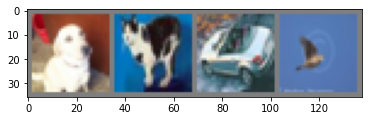

  dog   cat   car  bird


In [58]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [59]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# This makes model as data parallel model!
# If you erase this line, model will use only 1 GPU
net = nn.DataParallel(net)

net = net.to(device)

In [60]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [61]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.201
[1,  4000] loss: 1.815
[1,  6000] loss: 1.656
[1,  8000] loss: 1.547
[1, 10000] loss: 1.495
[1, 12000] loss: 1.450
[2,  2000] loss: 1.384
[2,  4000] loss: 1.378
[2,  6000] loss: 1.333
[2,  8000] loss: 1.327
[2, 10000] loss: 1.295
[2, 12000] loss: 1.292
Finished Training


# Multi GPU Training Example

* https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html
* https://medium.com/daangn/pytorch-multi-gpu-%ED%95%99%EC%8A%B5-%EC%A0%9C%EB%8C%80%EB%A1%9C-%ED%95%98%EA%B8%B0-27270617936b

In [48]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Parameters and DataLoaders
input_size = 5
output_size = 2

batch_size = 40
data_size = 100

In [49]:
class RandomDataset(Dataset):

    def __init__(self, size, length):
        self.len = length
        self.data = torch.randn(length, size)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.len

rand_loader = DataLoader(dataset=RandomDataset(input_size, data_size),
                         batch_size=batch_size, shuffle=True)

In [50]:
class Model(nn.Module):
    # Our model

    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, input):
        output = self.fc(input)
        print("\tIn Model: input size", input.size(),
              "output size", output.size())

        return output

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [52]:
model = Model(input_size, output_size).to(device)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [40, xxx] -> [10, ...], [10, ...], [10, ...], [10, ...] on 4 GPUs
    model = nn.DataParallel(model)

# model.to(device)

Let's use 4 GPUs!


In [53]:
for data in rand_loader:
    input = data.to(device)
    output = model(input)
    print("Outside: input size", input.size(),
          "output_size", output.size())

	In Model: input size torch.Size([10, 5]) output size torch.Size([10, 2])
	In Model: input size	In Model: input size torch.Size([10, 5]) output size torch.Size([10, 2])
 torch.Size([10, 5]) output size torch.Size([10, 2])
	In Model: input size torch.Size([10, 5]) output size torch.Size([10, 2])
Outside: input size torch.Size([40, 5]) output_size torch.Size([40, 2])
	In Model: input size torch.Size([10, 5]) output size torch.Size([10, 2])
	In Model: input size torch.Size([10, 5]) output size torch.Size([10, 2])
	In Model: input size torch.Size([10, 5]) output size torch.Size([10, 2])
	In Model: input size torch.Size([10, 5]) output size torch.Size([10, 2])
Outside: input size torch.Size([40, 5]) output_size torch.Size([40, 2])
	In Model: input size torch.Size([5, 5]) output size torch.Size([5, 2])
	In Model: input size torch.Size([5, 5]) output size torch.Size([5, 2])
	In Model: input size torch.Size([5, 5]) output size torch.Size([5, 2])
	In Model: input size torch.Size([5, 5]) output 

## Output shows

```
Outside: input size torch.Size([40, 5]) output_size torch.Size([40, 2])

In Model: input size torch.Size([10, 5]) output size torch.Size([10, 2])
In Model: input size torch.Size([10, 5]) output size torch.Size([10, 2])
In Model: input size torch.Size([10, 5]) output size torch.Size([10, 2])
In Model: input size torch.Size([10, 5]) output size torch.Size([10, 2])
```

### This means 40 batches of data are splitted as 4 unit of 10 batches, and each unit is processed on one GPU!